## Bitcoin and Ethereum price prediction with RNN LSTM


Importing needed libraries and installing Keras

In [1]:
import pandas as pd
import time
import matplotlib.pyplot as plt
import datetime
import numpy as np
import gc

# import the relevant Keras modules
#!pip install -q keras # this is not required if you are not using Google's colab
import keras
from keras.models import Sequential
from keras.layers import Activation, Dense
from keras.layers import LSTM
from keras.layers import Dropout

%matplotlib inline

Using TensorFlow backend.


In [0]:
neurons = 512 # number of hidden units in the LSTM layer
activation_function = 'tanh' # activation function for LSTM and Dense layer
loss = 'mae' # loss function for calculating the gradient, in this case Mean Absolute Error
optimizer="adam" # optimizer for appljying gradient decent
dropout = 2.5 # dropout ratio used after each LSTM layer to avoid overfitting
batch_size = 64
epochs = 50
window_len = 7 # is an intiger to be used as the look back window for creating a single input sample.
training_size = 0.8 # porportion of data to be used for training
merge_date = '2016-01-01' # the earliest date which we have data for both ETH and BTC or any other provided coin
split_date = '2017-09-01' # split point for the training and test set according to the training size, this is used for plotting 

In [0]:
def get_market_data(market, tag='None'):
  """
  market: the full name of the cryptocurrency as spelled on coinmarketcap.com. eg.: 'bitcoin'
  tag: eg.: 'btc', if provided it will add a tag to the name of every column.
  returns: panda DataFrame
  This function will use the coinmarketcap.com url for provided coin/token page. 
  Reads the OHLCV and Market Cap.
  Converts the date format to be readable. 
  Makes sure that the data is consistant by converting non_numeric values to a number very close to 0.
  And finally tags each columns if provided.
  """
  market_data = pd.read_html("https://coinmarketcap.com/currencies/" + market + 
                             "/historical-data/?start=20130428&end="+time.strftime("%Y%m%d"), flavor='html5lib')[0]
  market_data = market_data.assign(Date=pd.to_datetime(market_data['Date']))  
  market_data['Volume'] = (pd.to_numeric(market_data['Volume'], errors='coerce').fillna(0))
  if tag != 'None':
    market_data.columns = [market_data.columns[0]] + [tag + '_' + i for i in market_data.columns[1:]]
  return market_data


def merge_data(a, b, from_date=merge_date):
  """
  a: first DataFrame
  b: second DataFrame
  from_date: includes the data from the provided date and drops the any data before that date.
  returns merged data as Pandas DataFrame
  """
  merged_data = pd.merge(a, b, on=['Date'])
  merged_data = merged_data[merged_data['Date'] >= from_date]
  return merged_data


def add_volatility(data, coins=['btc', 'eth']):
  """
  data: input data, pandas DataFrame
  coins: default is for 'btc and 'eth'. It could be changed as needed
  This function calculates the volatility and close_off_high of each given coin in 24 hours, 
  and adds the result as new columns to the DataFrame.
  Return: DataFrame with added columns
  """
  for coin in coins:
    # calculate the daily change
    kwargs = {coin + '_change': lambda x: (x[coin + '_Close'] - x[coin + '_Open']) / x[coin + '_Open'],
             coin + '_close_off_high': lambda x: 2*(x[coin + '_High'] - x[coin + '_Close']) / (x[coin + '_High'] - x[coin + '_Low']) - 1,
             coin + '_volatility': lambda x: (x[coin + '_High'] - x[coin + '_Low']) / (x[coin + '_Open'])}
    data = data.assign(**kwargs)
  return data


def create_model_data(data):
  """
  data: pandas DataFrame
  This function drops unnecessary columns and reverses the order of DataFrame based on decending dates.
  Return: pandas DataFrame
  """
  data = data[['Date']+[coin+metric for coin in ['btc_', 'eth_'] for metric in ['Close','Volume','close_off_high','volatility']]]
  data = data.sort_values(by='Date')
  return data


def split_data(data, training_size=0.8):
  """
  data: Pandas Dataframe
  training_size: proportion of the data to be used for training
  This function splits the data into training_set and test_set based on the given training_size
  Return: train_set and test_set as pandas DataFrame
  """
  return data[:int(training_size*len(data))], data[int(training_size*len(data)):]


def create_inputs(data, coins=['btc', 'eth'], window_len=window_len):
  """
  data: pandas DataFrame, this could be either training_set or test_set
  coins: coin datas which will be used as the input. Default is 'btc', 'eth'
  window_len: is an intiger to be used as the look back window for creating a single input sample.
  This function will create input array X from the given dataset and will normalize 'Close' and 'Volume' between 0 and 1
  Return: X, the input for our model as a python list which later needs to be converted to numpy array.
  """
  norm_cols = [coin + metric for coin in coins for metric in ['_Close', '_Volume']]
  inputs = []
  for i in range(len(data) - window_len):
    temp_set = data[i:(i + window_len)].copy()
    inputs.append(temp_set)
    for col in norm_cols:
      inputs[i].loc[:, col] = inputs[i].loc[:, col] / inputs[i].loc[:, col].iloc[0] - 1  
  return inputs


def create_outputs(data, coin, window_len=window_len):
  """
  data: pandas DataFrame, this could be either training_set or test_set
  coin: the target coin in which we need to create the output labels for
  window_len: is an intiger to be used as the look back window for creating a single input sample.
  This function will create the labels array for our training and validation and normalize it between 0 and 1
  Return: Normalized numpy array for 'Close' prices of the given coin
  """
  return (data[coin + '_Close'][window_len:].values / data[coin + '_Close'][:-window_len].values) - 1


def to_array(data):
  """
  data: DataFrame
  This function will convert list of inputs to a numpy array
  Return: numpy array
  """
  x = [np.array(data[i]) for i in range (len(data))]
  return np.array(x)


def build_model(inputs, output_size, neurons, activ_func=activation_function, dropout=dropout, loss=loss, optimizer=optimizer):
  """
  inputs: input data as numpy array
  output_size: number of predictions per input sample
  neurons: number of neurons/ units in the LSTM layer
  active_func: Activation function to be used in LSTM layers and Dense layer
  dropout: dropout ration, default is 2.5
  loss: loss function for calculating the gradient
  optimizer: type of optimizer to backpropagate the gradient
  This function will build 3 layered RNN model with LSTM cells with dripouts after each LSTM layer 
  and finally a dense layer to produce the output using keras' sequential model.
  Return: Keras sequential model and model summary
  """
  model = Sequential()
  model.add(LSTM(neurons, return_sequences=True, input_shape=(inputs.shape[1], inputs.shape[2]), activation=activ_func))
  model.add(Dropout(dropout))
  model.add(LSTM(neurons, return_sequences=True, activation=activ_func))
  model.add(Dropout(dropout))
  model.add(LSTM(neurons, activation=activ_func))
  model.add(Dropout(dropout))
  model.add(Dense(units=output_size))
  model.add(Activation(activ_func))
  model.compile(loss=loss, optimizer=optimizer)
  model.summary()
  return model

In [0]:
def show_plot(data, tag):
  fig, (ax1, ax2) = plt.subplots(2,1, gridspec_kw = {'height_ratios':[3, 1]})
  ax1.set_ylabel('Closing Price ($)',fontsize=12)
  ax2.set_ylabel('Volume ($ bn)',fontsize=12)
  ax2.set_yticks([int('%d000000000'%i) for i in range(10)])
  ax2.set_yticklabels(range(10))
  ax1.set_xticks([datetime.date(i,j,1) for i in range(2013,2019) for j in [1,7]])
  ax1.set_xticklabels('')
  ax2.set_xticks([datetime.date(i,j,1) for i in range(2013,2019) for j in [1,7]])
  ax2.set_xticklabels([datetime.date(i,j,1).strftime('%b %Y')  for i in range(2013,2019) for j in [1,7]])
  ax1.plot(data['Date'].astype(datetime.datetime),data[tag +'_Open'])
  ax2.bar(data['Date'].astype(datetime.datetime).values, data[tag +'_Volume'].values)
  fig.tight_layout()
  plt.show()

In [0]:
btc_data = get_market_data("bitcoin", tag='btc')
eth_data = get_market_data("ethereum", tag='eth')

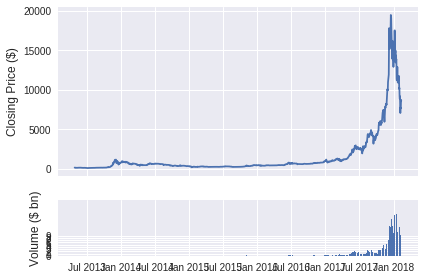

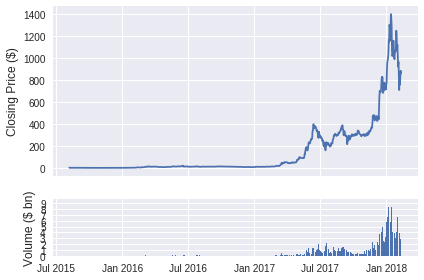

In [6]:
show_plot(btc_data, tag='btc')
show_plot(eth_data, tag='eth')

In [0]:
market_data = merge_data(btc_data, eth_data)
market_data = add_volatility(market_data)
model_data = create_model_data(market_data)
train_set, test_set = split_data(model_data)

In [8]:
model_data.tail()

,Date,btc_Close,btc_Volume,btc_close_off_high,btc_volatility,eth_Close,eth_Volume,eth_close_off_high,eth_volatility
4,2018-02-07,7621.30,9.169280e+09,0.395577,0.164054,757.07,3896180000,0.473429,0.161646
3,2018-02-08,8265.59,9.346750e+09,-0.363282,0.120572,817.81,3708190000,-0.388683,0.118081
2,2018-02-09,8736.98,6.784820e+09,-1.000000,0.103033,883.87,2495820000,-0.997268,0.116277
1,2018-02-10,8621.90,7.780960e+09,0.210645,0.094848,860.41,2930530000,0.241342,0.104049
0,2018-02-11,8129.97,6.122190e+09,0.419383,0.079506,814.66,2486650000,0.255945,0.082708


In [9]:
train_set = train_set.drop('Date', 1)
test_set = test_set.drop('Date', 1)

X_train = create_inputs(train_set)
Y_train_btc = create_outputs(train_set, coin='btc')
X_test = create_inputs(test_set)
Y_test_btc = create_outputs(test_set, coin='btc')

Y_train_eth = create_outputs(train_set, coin='eth')
Y_test_eth = create_outputs(test_set, coin='eth')

X_train, X_test = to_array(X_train), to_array(X_test)

print (np.shape(X_train), np.shape(X_test), np.shape(Y_train_btc), np.shape(Y_test_btc))
print (np.shape(X_train), np.shape(X_test), np.shape(Y_train_eth), np.shape(Y_test_eth))

(611, 7, 8) (148, 7, 8) (611,) (148,)
(611, 7, 8) (148, 7, 8) (611,) (148,)


In [10]:
# clean up the memory
gc.collect()

# random seed for reproducibility
np.random.seed(202)

# initialise model architecture
btc_model = build_model(X_train, output_size=1, neurons=neurons)

# train model on data
btc_history = btc_model.fit(X_train, Y_train_btc, epochs=epochs, batch_size=batch_size, verbose=1, validation_data=(X_test, Y_test_btc), shuffle=True)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 7, 512)            1067008   
_________________________________________________________________
dropout_1 (Dropout)          (None, 7, 512)            0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 7, 512)            2099200   
_________________________________________________________________
dropout_2 (Dropout)          (None, 7, 512)            0         
_________________________________________________________________
lstm_3 (LSTM)                (None, 512)               2099200   
_________________________________________________________________
dropout_3 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 513       
__________

611/611 [==============================] - 1s 1ms/step - loss: 0.0330 - val_loss: 0.0697
Epoch 7/50
611/611 [==============================] - 1s 1ms/step - loss: 0.0315 - val_loss: 0.0694
Epoch 8/50
611/611 [==============================] - 1s 1ms/step - loss: 0.0322 - val_loss: 0.0613
Epoch 9/50
611/611 [==============================] - 1s 1ms/step - loss: 0.0283 - val_loss: 0.0625
Epoch 10/50
611/611 [==============================] - 1s 1ms/step - loss: 0.0273 - val_loss: 0.0552
Epoch 11/50
611/611 [==============================] - 1s 1ms/step - loss: 0.0285 - val_loss: 0.0557
Epoch 12/50
611/611 [==============================] - 1s 1ms/step - loss: 0.0255 - val_loss: 0.0499
Epoch 13/50
611/611 [==============================] - 1s 1ms/step - loss: 0.0257 - val_loss: 0.0512
Epoch 14/50
611/611 [==============================] - 1s 1ms/step - loss: 0.0246 - val_loss: 0.0521
Epoch 15/50
611/611 [==============================] - 1s 1ms/step - loss: 0.0250 - val_loss: 0.0519
Epoch

611/611 [==============================] - 1s 1ms/step - loss: 0.0240 - val_loss: 0.0511
Epoch 20/50
611/611 [==============================] - 1s 1ms/step - loss: 0.0251 - val_loss: 0.0517
Epoch 21/50
611/611 [==============================] - 1s 1ms/step - loss: 0.0237 - val_loss: 0.0524
Epoch 22/50
611/611 [==============================] - 1s 1ms/step - loss: 0.0229 - val_loss: 0.0493
Epoch 23/50
611/611 [==============================] - 1s 1ms/step - loss: 0.0252 - val_loss: 0.0497
Epoch 24/50
611/611 [==============================] - 1s 1ms/step - loss: 0.0245 - val_loss: 0.0486
Epoch 25/50
611/611 [==============================] - 1s 1ms/step - loss: 0.0241 - val_loss: 0.0524
Epoch 26/50
611/611 [==============================] - 1s 1ms/step - loss: 0.0233 - val_loss: 0.0532
Epoch 27/50
611/611 [==============================] - 1s 1ms/step - loss: 0.0225 - val_loss: 0.0498
Epoch 28/50
611/611 [==============================] - 1s 1ms/step - loss: 0.0226 - val_loss: 0.0481
Ep

611/611 [==============================] - 1s 1ms/step - loss: 0.0231 - val_loss: 0.0573
Epoch 33/50
611/611 [==============================] - 1s 1ms/step - loss: 0.0231 - val_loss: 0.0491
Epoch 34/50
611/611 [==============================] - 1s 1ms/step - loss: 0.0230 - val_loss: 0.0487
Epoch 35/50
611/611 [==============================] - 1s 1ms/step - loss: 0.0225 - val_loss: 0.0492
Epoch 36/50
611/611 [==============================] - 1s 1ms/step - loss: 0.0223 - val_loss: 0.0482
Epoch 37/50
611/611 [==============================] - 1s 1ms/step - loss: 0.0221 - val_loss: 0.0486
Epoch 38/50
611/611 [==============================] - 1s 1ms/step - loss: 0.0217 - val_loss: 0.0504
Epoch 39/50
611/611 [==============================] - 1s 1ms/step - loss: 0.0216 - val_loss: 0.0489
Epoch 40/50
611/611 [==============================] - 1s 1ms/step - loss: 0.0219 - val_loss: 0.0487
Epoch 41/50
611/611 [==============================] - 1s 1ms/step - loss: 0.0215 - val_loss: 0.0485
Ep

611/611 [==============================] - 1s 1ms/step - loss: 0.0227 - val_loss: 0.0487
Epoch 46/50
611/611 [==============================] - 1s 1ms/step - loss: 0.0225 - val_loss: 0.0547
Epoch 47/50
611/611 [==============================] - 1s 1ms/step - loss: 0.0233 - val_loss: 0.0489
Epoch 48/50
611/611 [==============================] - 1s 1ms/step - loss: 0.0228 - val_loss: 0.0501
Epoch 49/50
611/611 [==============================] - 1s 1ms/step - loss: 0.0229 - val_loss: 0.0546
Epoch 50/50
611/611 [==============================] - 1s 1ms/step - loss: 0.0227 - val_loss: 0.0491


In [11]:
# clean up the memory
gc.collect()

# random seed for reproducibility
np.random.seed(202)

# initialise model architecture
eth_model = build_model(X_train, output_size=1, neurons=neurons)

# train model on data
eth_history = eth_model.fit(X_train, Y_train_eth, epochs=epochs, batch_size=batch_size, verbose=1, validation_data=(X_test, Y_test_eth), shuffle=True)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_4 (LSTM)                (None, 7, 512)            1067008   
_________________________________________________________________
dropout_4 (Dropout)          (None, 7, 512)            0         
_________________________________________________________________
lstm_5 (LSTM)                (None, 7, 512)            2099200   
_________________________________________________________________
dropout_5 (Dropout)          (None, 7, 512)            0         
_________________________________________________________________
lstm_6 (LSTM)                (None, 512)               2099200   
_________________________________________________________________
dropout_6 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 513       
__________

611/611 [==============================] - 1s 1ms/step - loss: 0.0668 - val_loss: 0.0558
Epoch 7/50
611/611 [==============================] - 1s 1ms/step - loss: 0.0644 - val_loss: 0.0555
Epoch 8/50
611/611 [==============================] - 1s 1ms/step - loss: 0.0618 - val_loss: 0.0534
Epoch 9/50
611/611 [==============================] - 1s 1ms/step - loss: 0.0594 - val_loss: 0.0502
Epoch 10/50
611/611 [==============================] - 1s 1ms/step - loss: 0.0591 - val_loss: 0.0493
Epoch 11/50
611/611 [==============================] - 1s 1ms/step - loss: 0.0589 - val_loss: 0.0623
Epoch 12/50
611/611 [==============================] - 1s 1ms/step - loss: 0.0661 - val_loss: 0.0474
Epoch 13/50
611/611 [==============================] - 1s 1ms/step - loss: 0.0586 - val_loss: 0.0486
Epoch 14/50
611/611 [==============================] - 1s 1ms/step - loss: 0.0563 - val_loss: 0.0482
Epoch 15/50
611/611 [==============================] - 1s 1ms/step - loss: 0.0559 - val_loss: 0.0556
Epoch

611/611 [==============================] - 1s 1ms/step - loss: 0.0561 - val_loss: 0.0531
Epoch 20/50
611/611 [==============================] - 1s 1ms/step - loss: 0.0591 - val_loss: 0.0509
Epoch 21/50
611/611 [==============================] - 1s 1ms/step - loss: 0.0550 - val_loss: 0.0513
Epoch 22/50
611/611 [==============================] - 1s 1ms/step - loss: 0.0536 - val_loss: 0.0565
Epoch 23/50
611/611 [==============================] - 1s 1ms/step - loss: 0.0573 - val_loss: 0.0547
Epoch 24/50
611/611 [==============================] - 1s 1ms/step - loss: 0.0592 - val_loss: 0.0493
Epoch 25/50
611/611 [==============================] - 1s 1ms/step - loss: 0.0553 - val_loss: 0.0479
Epoch 26/50
611/611 [==============================] - 1s 1ms/step - loss: 0.0523 - val_loss: 0.0505
Epoch 27/50
611/611 [==============================] - 1s 1ms/step - loss: 0.0530 - val_loss: 0.0540
Epoch 28/50
611/611 [==============================] - 1s 1ms/step - loss: 0.0547 - val_loss: 0.0493
Ep

611/611 [==============================] - 1s 1ms/step - loss: 0.0515 - val_loss: 0.0506
Epoch 33/50
611/611 [==============================] - 1s 1ms/step - loss: 0.0544 - val_loss: 0.0498
Epoch 34/50
611/611 [==============================] - 1s 1ms/step - loss: 0.0530 - val_loss: 0.0514
Epoch 35/50
611/611 [==============================] - 1s 1ms/step - loss: 0.0530 - val_loss: 0.0542
Epoch 36/50
611/611 [==============================] - 1s 1ms/step - loss: 0.0543 - val_loss: 0.0531
Epoch 37/50
611/611 [==============================] - 1s 1ms/step - loss: 0.0556 - val_loss: 0.0493
Epoch 38/50
611/611 [==============================] - 1s 1ms/step - loss: 0.0540 - val_loss: 0.0496
Epoch 39/50
611/611 [==============================] - 1s 1ms/step - loss: 0.0536 - val_loss: 0.0512
Epoch 40/50
611/611 [==============================] - 1s 1ms/step - loss: 0.0537 - val_loss: 0.0491
Epoch 41/50
611/611 [==============================] - 1s 1ms/step - loss: 0.0531 - val_loss: 0.0501
Ep

611/611 [==============================] - 1s 1ms/step - loss: 0.0511 - val_loss: 0.0499
Epoch 46/50
611/611 [==============================] - 1s 1ms/step - loss: 0.0510 - val_loss: 0.0498
Epoch 47/50
611/611 [==============================] - 1s 1ms/step - loss: 0.0509 - val_loss: 0.0574
Epoch 48/50
611/611 [==============================] - 1s 1ms/step - loss: 0.0537 - val_loss: 0.0532
Epoch 49/50
611/611 [==============================] - 1s 1ms/step - loss: 0.0534 - val_loss: 0.0540
Epoch 50/50
611/611 [==============================] - 1s 1ms/step - loss: 0.0546 - val_loss: 0.0498


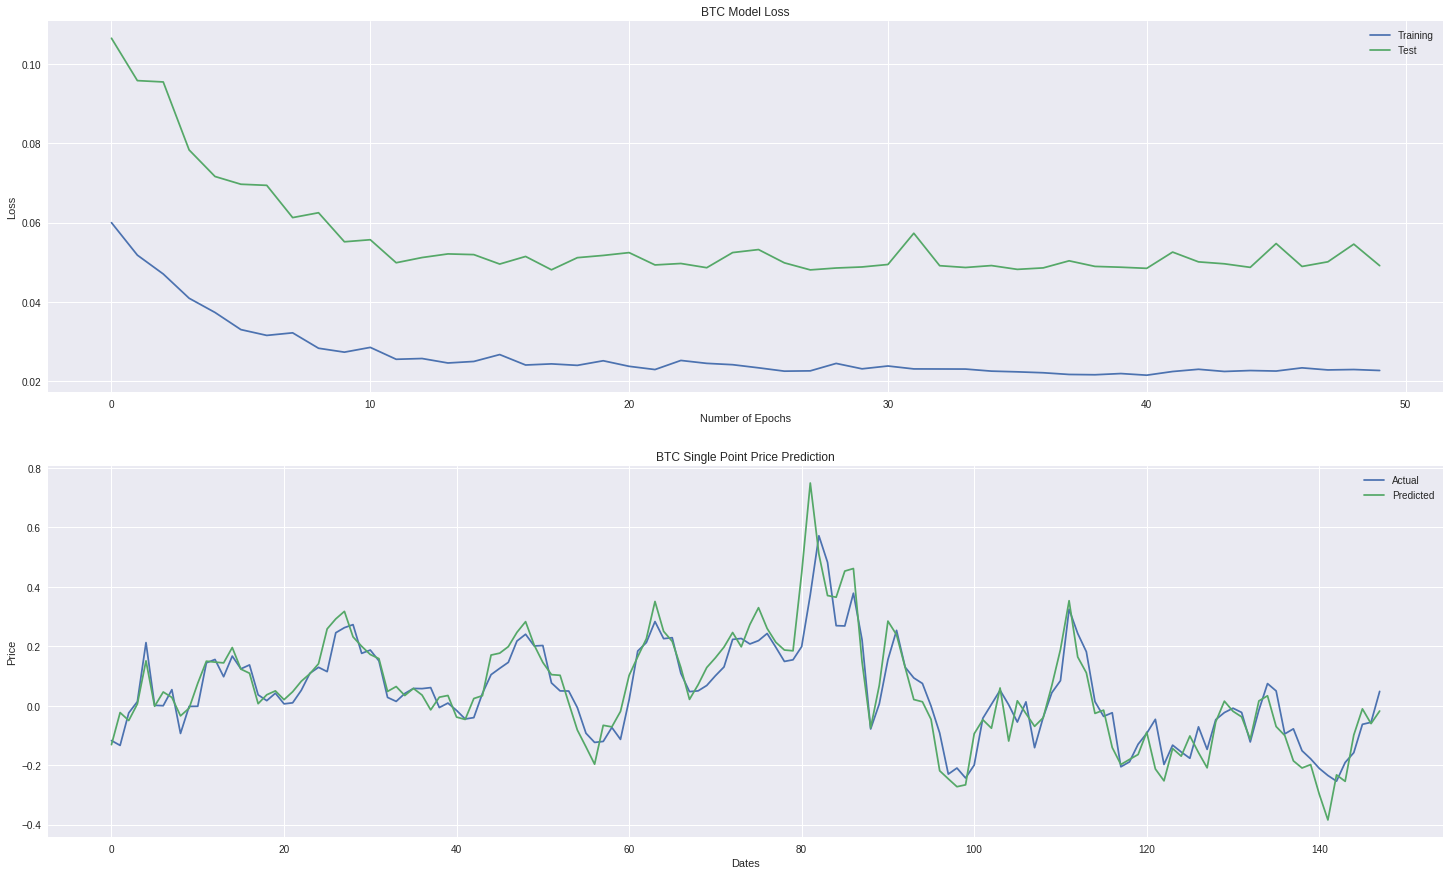

In [12]:
plt.figure(figsize=(25, 15))
plt.subplot(211)
plt.plot(btc_history.epoch, btc_history.history['loss'], )
plt.plot(btc_history.epoch, btc_history.history['val_loss'])
plt.xlabel('Number of Epochs')
plt.ylabel('Loss')
plt.title('BTC Model Loss')
plt.legend(['Training', 'Test'])

plt.subplot(212)
plt.plot(btc_model.predict(X_test))
plt.plot(Y_test_btc)
plt.xlabel('Dates')
plt.ylabel('Price')
plt.title('BTC Single Point Price Prediction')
plt.legend(['Actual', 'Predicted'])
plt.show()

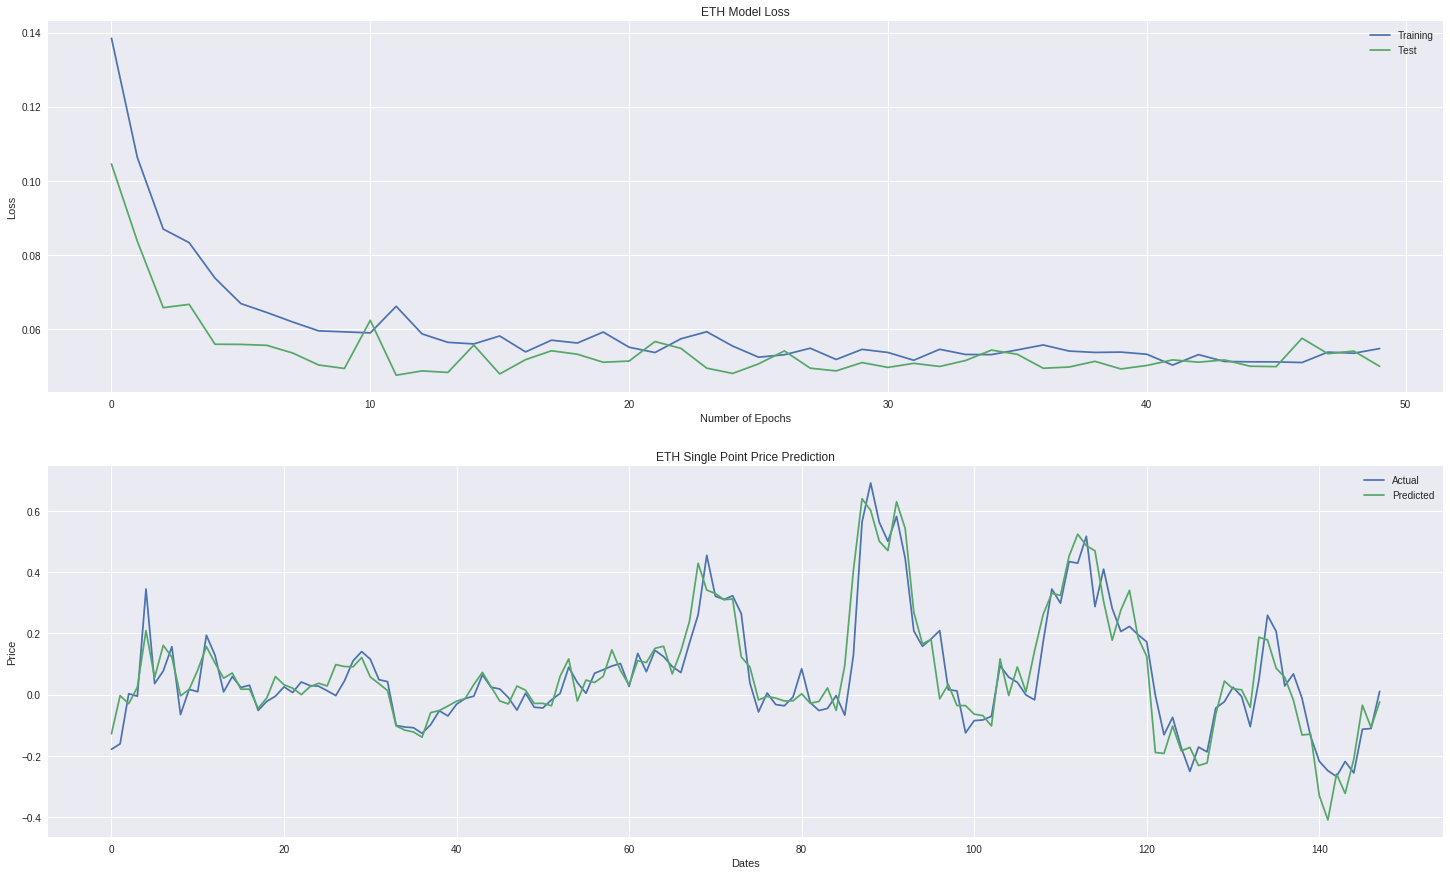

In [13]:
plt.figure(figsize=(25, 15)) 
plt.subplot(211)
plt.plot(eth_history.epoch, eth_history.history['loss'], )
plt.plot(eth_history.epoch, eth_history.history['val_loss'])
plt.xlabel('Number of Epochs')
plt.ylabel('Loss')
plt.title('ETH Model Loss')
plt.legend(['Training', 'Test'])
plt.subplot(212)
plt.plot(eth_model.predict(X_test))
plt.plot(Y_test_eth)
plt.xlabel('Dates')
plt.ylabel('Price')
plt.title('ETH Single Point Price Prediction')
plt.legend(['Actual', 'Predicted'])
plt.show()